<a href="https://colab.research.google.com/github/royn5618/Deep-Learning-Things/blob/main/NLP/DataLoader_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reference :**
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

**Notes:**

PyTorch provides two data primitives to allow using pre-loaded datasets or your own data: 
1. torch.utils.data.DataLoader
2. torch.utils.data.Dataset


# Loading a Dataset

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",  # root is the path where the train/test data is stored
    train=True,  # bool: train specifies training or test dataset
    download=True,  # downloads data from the internet if not available at root
    transform=ToTensor()   # specify the feature and label transformations 
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # False cz it is not the train set
    download=True,
    transform=ToTensor()
)

# Creating a Custom Dataset for your files

In [2]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, 
                 transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) 
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)  # ideally returns the length of the labels

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Preparing data for training with DataLoaders

The **Dataset** retrieves our dataset’s features and labels one sample at a time.

DataLoader allows us to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval FOR training a model.

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader

Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively).

In [4]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


Noteice the 64 in the shape of the features and labels.

## Visualize an image in the train batch

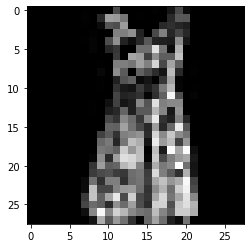

Label: 3


In [5]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Build a Model

* The torch.nn namespace provides all the building blocks needed to build NNs
* Every module in PyTorch subclasses the nn.Module
* A neural network is a module itself that consists of other modules (layers)

## Get Device for Training

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
X = torch.rand(1, 28, 28, device=device)  #input
logits = model(X) # pass the input to the model. DO NOT CALL forward directly.

The model returns a 10-dimensional tensor with raw predicted values for each class. 

In [10]:
logits  # raw predicted values

tensor([[-0.0345,  0.1406, -0.1050,  0.0666, -0.0758,  0.0412, -0.1476,  0.0120,
         -0.1105, -0.0118]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
pred_probab = nn.Softmax(dim=1)(logits)  # prediction probabilities 
pred_probab


tensor([[0.0984, 0.1173, 0.0917, 0.1089, 0.0945, 0.1062, 0.0879, 0.1031, 0.0912,
         0.1007]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

highest prob -> 0.1173 in the 6th tensor (count starts from 0) or the 7th position

In [12]:
y_pred = pred_probab.argmax(1)  # get the highest prob
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1], device='cuda:0')


# Optimizing Model HyperParameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates
* No of epochs
* learning rate
* batch size

In [13]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
* The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

* The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

**Loss function** measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. 

**Optimization** is the process of adjusting model parameters to reduce model error in each training step, ie. the **loss**.



In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # initializing stochastic gradient descent

## Train Loop

loops over our optimization code

Inside the training loop, optimization happens in three steps:
1. Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
2. Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.
3. Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.



In [38]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device)) # calls the model for predictions
        loss = loss_fn(pred, y.to(device)) # gets the loss by comparing the prediction(pred) and the actual(y)

        # Backpropagation
        optimizer.zero_grad() # step 1 - resets the gradient
        loss.backward() # step 2 - propagates the error backward
        optimizer.step() # step 3 - Performs a single optimization step

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


## Test Loop

evaluates the model’s performance against our test data

In [42]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Run to train and evluate the model

In [46]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.719414  [    0/60000]
loss: 1.065405  [ 6400/60000]
loss: 0.786717  [12800/60000]
loss: 0.847479  [19200/60000]
loss: 0.794212  [25600/60000]
loss: 0.936504  [32000/60000]
loss: 0.740786  [38400/60000]
loss: 0.886059  [44800/60000]
loss: 0.766301  [51200/60000]
loss: 0.833832  [57600/60000]
Test Error: 
 Accuracy: 68.4%, Avg loss: 0.855189 

Epoch 2
-------------------------------
loss: 0.778386  [    0/60000]
loss: 0.836157  [ 6400/60000]
loss: 0.931459  [12800/60000]
loss: 0.925169  [19200/60000]
loss: 0.789799  [25600/60000]
loss: 0.899586  [32000/60000]
loss: 0.892853  [38400/60000]
loss: 0.870776  [44800/60000]
loss: 0.802944  [51200/60000]
loss: 0.782164  [57600/60000]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.815768 

Epoch 3
-------------------------------
loss: 0.709200  [    0/60000]
loss: 0.675803  [ 6400/60000]
loss: 0.759618  [12800/60000]
loss: 0.721134  [19200/60000]
loss: 0.764316  [25600/60000]
loss: 0.784264  [32000/600

# Save and Load the Model

In [47]:
import torchvision.models as models
torch.save(model.state_dict(), 'model_weights.pth')

In [48]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)